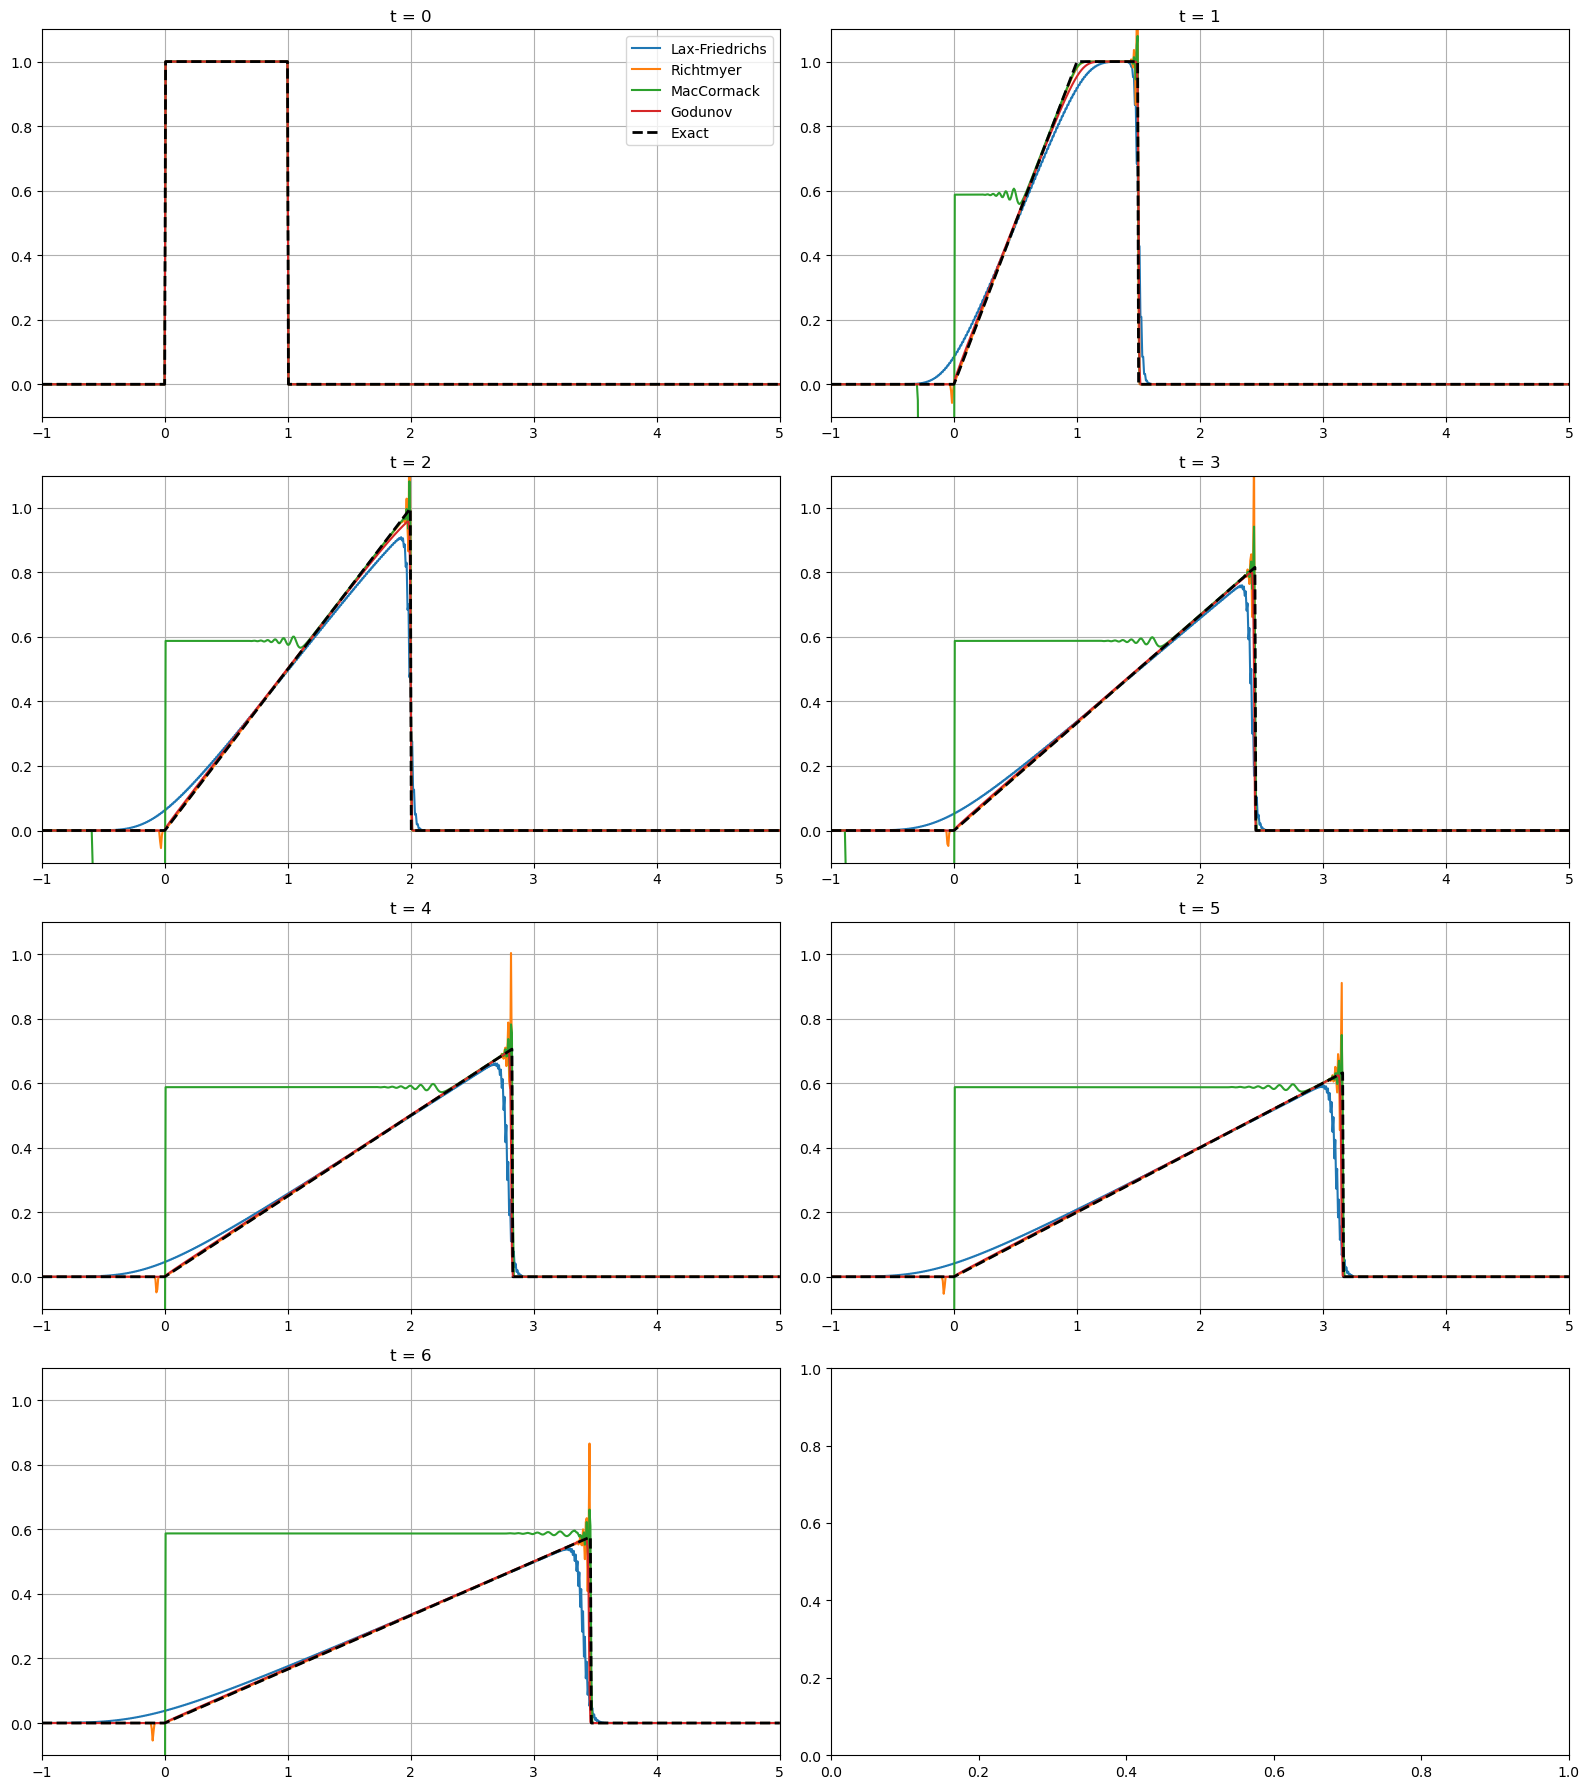

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def flux(u):
    return 0.5 * u**2

def initial_condition(x):
    u0 = np.zeros_like(x)
    u0[(x >= 0) & (x <= 1)] = 1
    return u0

def exact_solution(x, t):
    u = np.zeros_like(x)
    if t < 2.0:
        for i in range(len(x)):
            xi = x[i]
            if xi < 0:
                u[i] = 0
            elif xi < t:
                u[i] = xi / t
            elif xi < 1 + 0.5*t:
                u[i] = 1
            else:
                u[i] = 0
        return u
    else:
        for i in range(len(x)):
            xi = x[i]
            if xi < 0:
                u[i] = 0
            elif xi < np.sqrt(2*t):
                u[i] = xi / t
            else:
                u[i] = 0
    return u

def lax_friedrichs(u, dx, dt):
    u_new = np.zeros_like(u)
    r = dt/dx
    for j in range(1, len(u)-1):
        u_new[j] = 0.5 * (u[j+1] + u[j-1]) - 0.5 * r * (flux(u[j+1]) - flux(u[j-1]))
    u_new[0] = u_new[1]
    u_new[-1] = u_new[-2]
    return u_new

def richtmyer(u, dx, dt):
    u_new = np.zeros_like(u)
    r = dt/dx
    u_half = np.zeros(len(u))
    for j in range(len(u)-1):
        u_half[j] = 0.5 * (u[j] + u[j+1]) - 0.5 * r * (flux(u[j+1]) - flux(u[j]))
    for j in range(1, len(u)-1):
        u_new[j] = u[j] - r * (flux(u_half[j]) - flux(u_half[j-1]))
    u_new[0] = u_new[1]
    u_new[-1] = u_new[-2]
    return u_new

def maccormack(u, dx, dt):
    u_star = np.zeros_like(u)
    u_new = np.zeros_like(u)
    r = dt/dx
    for j in range(len(u)-1):
        u_star[j] = u[j] - r * (flux(u[j+1]) - flux(u[j]))
    u_star[-1] = u_star[-2]
    for j in range(1, len(u)):
        u_new[j] = 0.5 * (u[j] + u_star[j] - r * (flux(u_star[j]) - flux(u_star[j-1])))
    u_new[0] = u_new[1]
    return u_new

def godunov(u, dx, dt):
    u_new = np.zeros_like(u)
    r = dt / dx
    for j in range(1, len(u) - 1):
        ul, ur = u[j-1], u[j]
        if ul > ur:
            s = 0.5 * (ul + ur)
            if s > 0:
                f = flux(ul)
            else:
                f = flux(ur)
        else:
            f = min(flux(ul), flux(ur))
        fl = f

        ul, ur = u[j], u[j+1]
        if ul > ur:
            s = 0.5 * (ul + ur)
            if s > 0:
                f = flux(ul)
            else:
                f = flux(ur)
        else:
            f = min(flux(ul), flux(ur))
        fr = f

        u_new[j] = u[j] - r * (fr - fl)
    u_new[0] = u_new[1]
    u_new[-1] = u_new[-2]
    return u_new

def solve_burgers(method, x, dx, dt, times):
    u = initial_condition(x)
    t = 0
    nt = int(max(times) / dt) + 1
    result = {}
    for n in range(nt):
        if any(abs(t - tau) < dt/2 for tau in times):
            result[round(t, 2)] = u.copy()
        u = method(u, dx, dt)
        t += dt
    return result

x_min, x_max = -1, 5
nx = 800
x = np.linspace(x_min, x_max, nx)
dx = x[1] - x[0]
dt = 0.5 * dx
times = [0, 1, 2, 3, 4, 5, 6]

results = {
    'Lax-Friedrichs': solve_burgers(lax_friedrichs, x, dx, dt, times),
    'Richtmyer': solve_burgers(richtmyer, x, dx, dt, times),
    'MacCormack': solve_burgers(maccormack, x, dx, dt, times),
    'Godunov': solve_burgers(godunov, x, dx, dt, times),
    'Exact': {t: exact_solution(x, t) for t in times}
}

# Plotting
fig, axs = plt.subplots(4, 2, figsize=(16, 18))
methods = list(results.keys())[:-1]

for i, t in enumerate(times):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    for method in methods:
        ax.plot(x, results[method][round(t, 2)], label=method)
    ax.plot(x, results['Exact'][t], 'k--', linewidth=2, label='Exact')
    ax.set_title(f't = {t}')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(-0.1, 1.1)
    ax.grid(True)
    if i == 0:
        ax.legend()
plt.tight_layout()
plt.show()